In [21]:
from pathlib import Path
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots

name_mapping = {
    'control': 'Control (Retrain)',
    'certified_deep_unlearning': 'Certified Deep Unlearning',
    'amnesiac': 'Amnesiac',
    'bad_teacher': 'Bad Teacher',
    'ssd': "SSD"
}

In [22]:
distinguisher_to_plot = 'kld'
poison_type = 'badnets'
experiment_dir = Path(f'/home/unlearning/mirror-mirror/output/{poison_type}_poison_cifar10_resnet18_32_trials')

In [23]:
distinguisher_dfs = []

# Get the distinguisher data
for p in experiment_dir.iterdir():
    if p.name.endswith('csv'):
        distinguisher_name = p.stem.split('_')[0]
        distinguisher_df = pd.read_csv(str(p))
        if 'accuracy' not in p.stem.split('_') and 'tpr' not in p.stem.split('_'):
            distinguisher_df['distinguisher'] = [distinguisher_name] * len(distinguisher_df.index)
            distinguisher_df['poison_rate'] = distinguisher_df['forget_set'].apply(lambda x: float(x.split('_')[1]))
            distinguisher_dfs.append(distinguisher_df)

# Add in performance figures
for df in distinguisher_dfs:
    clean_acc_df = pd.read_csv(str(experiment_dir / 'clean_accuracy_results.csv'))
    poison_acc_df = pd.read_csv(str(experiment_dir / 'poison_accuracy_results.csv'))
    df['clean_accuracy'] = clean_acc_df['score']#.apply(lambda x: x * 100)
    df['poison_accuracy'] = poison_acc_df['score']#.apply(lambda x: x * 100)

data_df = pd.concat(distinguisher_dfs, axis=0)
data_df['model'] = data_df['model'].apply(lambda x: name_mapping[x])
data_df = data_df[data_df['poison_rate'] == 0.1]
data_df.head()

,forget_set,run_number,model,score,distinguisher,poison_rate,clean_accuracy,poison_accuracy
0,poison_0.1,0,Control (Retrain),9.246273,kld,0.1,0.8315,0.1021
1,poison_0.1,0,SSD,0.012730,kld,0.1,0.8252,0.9102
2,poison_0.1,0,Bad Teacher,1.815114,kld,0.1,0.8072,0.2517
3,poison_0.1,0,Amnesiac,6.617466,kld,0.1,0.8037,0.0108
4,poison_0.1,1,Control (Retrain),9.195787,kld,0.1,0.8244,0.0980


In [24]:
diffs_dfs = []
control_scores = data_df[data_df['model'] == 'Control (Retrain)'].reset_index(drop=True)['score']
for c in data_df['model'].unique():
    if 'Control' not in c:
        curr_df = data_df[data_df['model'] == c].reset_index(drop=True)
        curr_scores = curr_df['score']
        curr_diffs = np.abs(curr_scores - control_scores)
        curr_df['control_score_diffs'] = curr_diffs
        diffs_dfs.append(curr_df)
diffs_df = pd.concat(diffs_dfs)
diffs_df.head()
    

,forget_set,run_number,model,score,distinguisher,poison_rate,clean_accuracy,poison_accuracy,control_score_diffs
0,poison_0.1,0,SSD,0.012730,kld,0.1,0.8252,0.9102,9.233543
1,poison_0.1,1,SSD,0.183944,kld,0.1,0.8219,0.8141,9.011843
2,poison_0.1,2,SSD,5.435855,kld,0.1,0.7818,0.0481,3.694003
3,poison_0.1,3,SSD,5.607793,kld,0.1,0.7717,0.0314,3.547348
4,poison_0.1,4,SSD,0.118432,kld,0.1,0.8296,0.8490,8.982550


In [25]:
data_df[data_df['model'] == 'Control (Retrain)']

,forget_set,run_number,model,score,distinguisher,poison_rate,clean_accuracy,poison_accuracy
0,poison_0.1,0,Control (Retrain),9.246273,kld,0.1,0.8315,0.1021
4,poison_0.1,1,Control (Retrain),9.195787,kld,0.1,0.8244,0.0980
8,poison_0.1,2,Control (Retrain),9.129858,kld,0.1,0.8286,0.0995
12,poison_0.1,3,Control (Retrain),9.155142,kld,0.1,0.8269,0.0978
16,poison_0.1,4,Control (Retrain),9.100983,kld,0.1,0.8329,0.1020
...,...,...,...,...,...,...,...,...
108,poison_0.1,27,Control (Retrain),0.121074,mse,0.1,0.8322,0.0995
112,poison_0.1,28,Control (Retrain),0.118750,mse,0.1,0.8389,0.1026
116,poison_0.1,29,Control (Retrain),0.122000,mse,0.1,0.8305,0.0990
120,poison_0.1,30,Control (Retrain),0.122923,mse,0.1,0.8308,0.0991


In [26]:
diffs_plot_df = diffs_df.drop(['forget_set'], axis=1)
diffs_plot_df = diffs_plot_df.groupby(['poison_rate', 'distinguisher', 'model']).agg(
    mean_score_diff=('control_score_diffs', 'mean'),
    std_score_diff=('control_score_diffs', 'std'),
    mean_poison_accuracy=('poison_accuracy', 'mean'),
    std_poison_accuracy=('poison_accuracy', 'std'),
    mean_clean_accuracy=('clean_accuracy', 'mean'),
    std_clean_accuracy=('clean_accuracy', 'std')
).reset_index()
diffs_plot_df.head()

,poison_rate,distinguisher,model,mean_score_diff,std_score_diff,mean_poison_accuracy,std_poison_accuracy,mean_clean_accuracy,std_clean_accuracy
0,0.1,kld,Amnesiac,2.716452,0.312043,0.009134,0.002982,0.798103,0.005827
1,0.1,kld,Bad Teacher,6.509571,0.706889,0.062306,0.096878,0.809981,0.005391
2,0.1,kld,SSD,6.436390,2.576755,0.380291,0.337787,0.805444,0.022801
3,0.1,mia,Amnesiac,0.572581,0.009745,0.009134,0.002982,0.798103,0.005827
4,0.1,mia,Bad Teacher,0.576169,0.009922,0.062306,0.096878,0.809981,0.005391


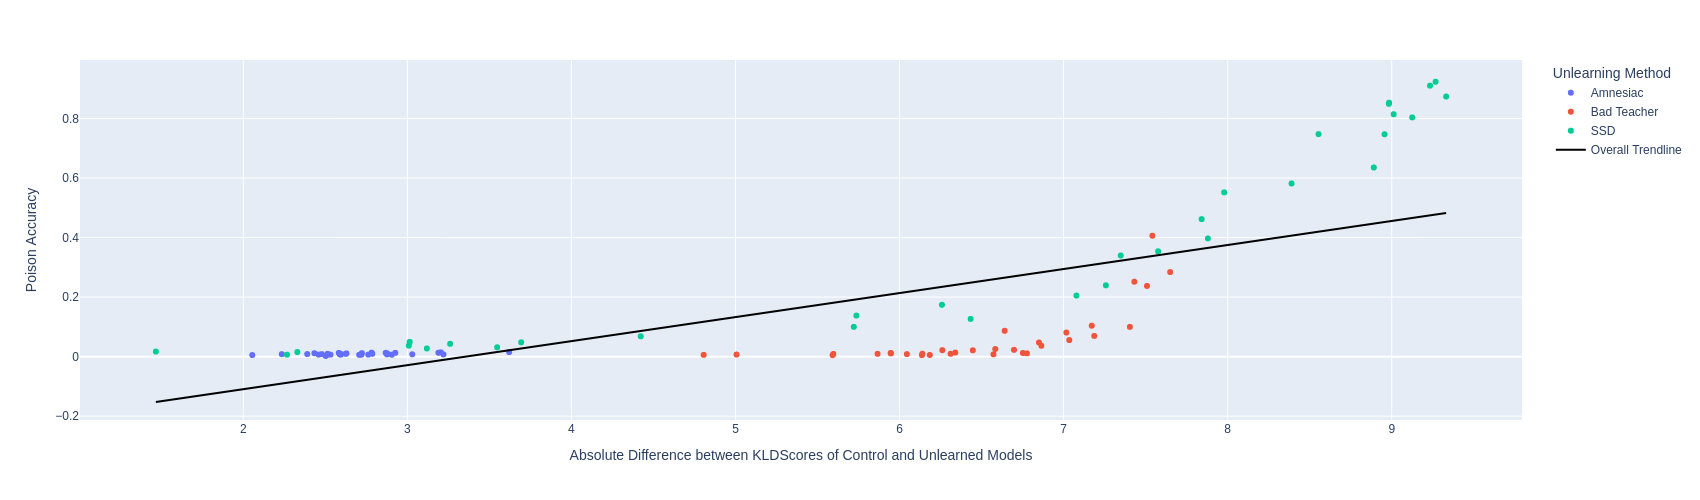

In [27]:
control_performance = data_df[data_df['model'] == 'Control (Retrain)'].reset_index(drop=True)['poison_accuracy']

# fig = px.scatter(
#     diffs_df[(diffs_df['distinguisher'] == 'mia')],
#     x='control_score_diffs',
#     y='poison_accuracy',
#     color='model',
#     labels={
#         'model': 'Unlearning Method',
#         'control_score_diffs': "Absolute Difference in KLD Scores",
#         'poison_accuracy': "Poison Accuracy"
#     },
#     category_orders={'model': ['Amnesiac', 'Bad Teacher', 'SSD']},
#     trendline="ols",
#     trendline_scope="overall",
#     trendline_color_override="black"
# )
# fig.update_xaxes(title_text="Absolute Difference between MIA scores of Control and Unlearned Models", row=1, col=1)
# fig.update_yaxes(title_text="Poison Accuracy", row=1, col=1)

fig = px.scatter(
    diffs_df[diffs_df['distinguisher'] == 'kld'],
    x='control_score_diffs',
    y='poison_accuracy',
    color='model',
    labels={
        'model': 'Unlearning Method',
        'control_score_diffs': "Absolute Difference in KLDScores",
        'poison_accuracy': "Poison Accuracy"
    },
    category_orders={'model': ['Amnesiac', 'Bad Teacher', 'SSD']},
    trendline="ols",
    trendline_scope="overall",
    trendline_color_override="black"
)
fig.update_xaxes(title_text="Absolute Difference between KLDScores of Control and Unlearned Models")
fig.update_yaxes(title_text="Poison Accuracy")

# Add line for control performance
# fig.add_hline(
#     y=control_performance.mean(), 
#     opacity=1, 
#     line_width=3, 
#     line_dash='dash', 
#     line_color='Black', 
#     annotation_text=f'Control Performance: {control_performance.mean():.3f}', 
#     annotation_position='top left', 
#     annotation_font_size=14
# )

fig.show(renderer='png', width=1700, height=500)

In [28]:
results = px.get_trendline_results(fig).iloc[0]['px_fit_results']
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     107.8
Date:                Fri, 19 Sep 2025   Prob (F-statistic):           2.83e-17
Time:                        20:01:09   Log-Likelihood:                 30.392
No. Observations:                  96   AIC:                            -56.78
Df Residuals:                      94   BIC:                            -51.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2708      0.044     -6.089      0.0

In [29]:
results.tvalues

array([-6.0886906 , 10.38274278])

In [30]:
import tikzplotly
tikzplotly.save("kld_vs_poison.tex", fig)

/home/mathepa1/miniconda3/envs/unlearning/lib/python3.12/site-packages/tikzplotly/_axis.py:149: UserWarning:

The categoryorder option is not supported (yet 🤞) for the axis environment.

